In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

transform_test = transforms.Compose(
    [
        transforms.Resize(256), 
        transforms.RandomCrop(224), 
        transforms.ToTensor(), 
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225)
        )
    ]
)


data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


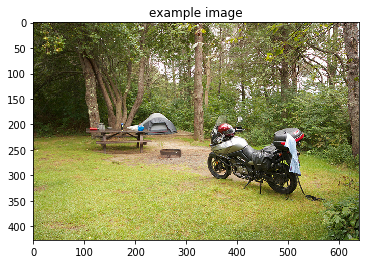

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
% load_ext autoreload
% autoreload 2
%reload_ext autoreload

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = 'encoder-batch_size-32-1.pkl'
decoder_file = 'decoder-batch_size-32-1.pkl'

embed_size = 512
hidden_size = 512
vocab_size = len(data_loader.dataset.vocab)
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

encoder.to(device)
decoder.to(device)

DecoderRNN(
  (turn_to_embeddings): Embedding(8099, 512)
  (layer_lstm): LSTM(512, 512, batch_first=True)
  (fc1): Linear(in_features=512, out_features=8099, bias=True)
)

In [5]:
image = image.to(device)

features = encoder(image).unsqueeze(1)
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 169, 139, 3, 140, 54, 3, 1952, 1080, 18, 1]


In [6]:
def clean_sentence(output):
    sentence = ''
    for vec in output:
        block = data_loader.dataset.vocab.idx2word[vec]
        if vec == 1:
            break
        elif vec == 0:
            continue
        elif vec == 18:
            sentence = sentence + block
        else:
            sentence = sentence + ' ' + block
    return sentence.strip()

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man riding a bike down a dirt path.


In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

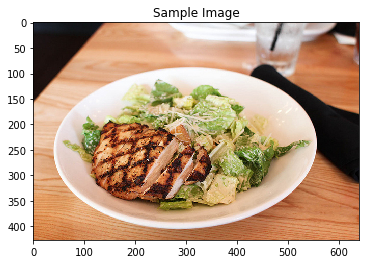

a plate of food with broccoli and tomatoes.


In [9]:
get_prediction()

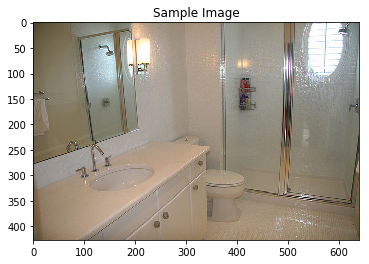

a bathroom with a toilet and a sink


In [17]:
get_prediction()

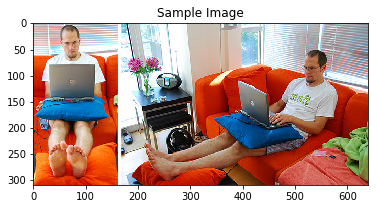

a man sitting on a couch with a laptop computer.


In [11]:
get_prediction()

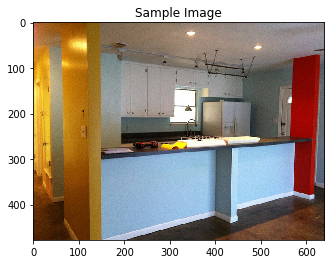

a bathroom with a sink , toilet and shower.


In [18]:
get_prediction()

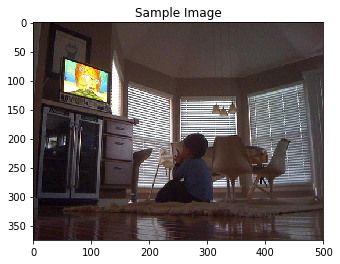

a group of people sitting around a table with laptops.


In [19]:
get_prediction()